# Run "Classic" pandas version of processing with Numpyro Baysian method

In [24]:
import pandas as pd
#import MarineDNA as md
import plotly.express as px
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

import itertools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import the data

In [31]:
file1 = "../Data/merged_data/no_duplicates/Merged2018_16S_otu_filtered.csv"
file2 = "../Data/merged_data/no_duplicates/Merged2018_18S_otu_filtered.csv"
asvs_16S = pd.read_csv(file1, index_col=0)
asvs_18S = pd.read_csv(file2, index_col=0)
'''
print('Number of 16S ASVs:', len(asvs_16S))
print('Number of 16S samples:', len(list(asvs_16S)))
print('Number of 18S ASVs:', len(asvs_18S))
print('Number of 18S samples:', len(list(asvs_18S)))
'''

"\nprint('Number of 16S ASVs:', len(asvs_16S))\nprint('Number of 16S samples:', len(list(asvs_16S)))\nprint('Number of 18S ASVs:', len(asvs_18S))\nprint('Number of 18S samples:', len(list(asvs_18S)))\n"

In [41]:
# get lists of sample and asv names
labels_samples_16S = list(asvs_16S)
labels_samples_18S = list(asvs_18S)
labels_asvs_16S = asvs_16S.index.tolist()
labels_asvs_18S = asvs_18S.index.tolist()

print('Number of 16S ASVs:', len(labels_asvs_16S))
print('Number of 16S samples:', len(labels_samples_16S))
print('Number of 18S ASVs:', len(labels_asvs_18S))
print('Number of 18S samples:', len(labels_samples_18S))

Number of 16S ASVs: 7077
Number of 16S samples: 131
Number of 18S ASVs: 10475
Number of 18S samples: 131


## Functions

In [42]:
# Return data frame of a draw of relative percent of occurrence from a beta distribution
# fit to observed occurrence counts
#   df: data frame where rows = ASVs and columns = samples
def ranRelPct(df, asLogOdds = True):
    import pandas as pd
    import numpy as np
    
    def betaCol(col):
        beta_dist = np.random.beta(col + 1, col.sum() - col + 1)
        return beta_dist / beta_dist.sum()
    result = np.empty([df.shape[0], df.shape[1]])
    for i in range(result.shape[1]):
        result[:,i] = betaCol(df.iloc[:,i])
    if asLogOdds:
        result = np.log(result / (1 - result))
    return pd.DataFrame(result, index = df.index, columns = df.columns).transpose()

In [43]:
# Does hierarchical clustering on data frame where rows are samples and columns are ASVs
# Returns array of cluster labels for rows
def doClustering(df, num_clusts, num_pcs = None):
    from sklearn.cluster import AgglomerativeClustering
    
    agg_clust = AgglomerativeClustering(n_clusters = num_clusts, metric = "euclidean", linkage = "ward")
    labels = agg_clust.fit_predict(df)
    return labels.astype(str)

In [44]:
def pctSame(df, n_clust, n_rep):
    if n_clust >= df.shape[0]:
        return 100
    
    def isSameCluster(pws, df, col):
        return df.iloc[pws[0], col] == df.iloc[pws[1], col]
    
    def maxSame(row):
        unique, counts = np.unique(row, return_counts=True)
        return max(counts)
    
    # cluster a random sample of logit(relative percentages)
    cluster_samples = [md.doClustering(md.ranRelPct(df), n_clust) for i in range(n_rep)]
    cluster_samples = pd.DataFrame(cluster_samples).transpose()
    # unique pairs of rows
    *pws_rows, = itertools.combinations(range(cluster_samples.shape[0]), 2)
    pws_same = np.empty([len(pws_rows), n_rep])
    for c in range(pws_same.shape[1]):
        for r in range(pws_same.shape[0]):
            pws_same[r, c] = cluster_samples.iloc[pws_rows[r][0], c] == cluster_samples.iloc[pws_rows[r][1], c]
    
    # get the maximum number replicates that have the same value (True or False) for each sample
    num_same = [maxSame(pws_same[row, :]) for row in range(pws_same.shape[0])]
    # convert to percentage with maximum of same value across all replicates
    return np.sum(num_same) * 100 / (pws_same.shape[0] * pws_same.shape[1])

In [45]:
# Does PCA
#   df: data frame where rows = samples and columns = ASVs
#   num_pcs: number of components to return. if None, return maximum number
# Returns a dictionary containing :
#   scores: array of PCA scores
#   loadings: array of PCA loadings
def doPCA(df, num_pcs = None):
    import numpy as np
    from sklearn.decomposition import PCA
    
    max_pcs = min(df.shape[0] - 1, df.shape[1] - 1)
    if num_pcs is None:
        num_pcs = max_pcs
    elif num_pcs > max_pcs:
        num_pcs = max_pcs
    pca = PCA(n_components = num_pcs)
    pca_fit = pca.fit(df)
    pca_results = {
        "scores": pca_fit.transform(df),
        "loadings": np.transpose(pca_fit.components_),
        "explained_variance": pca.explained_variance_ratio_
        # add line exported explained variance
    }
    return pca_results

## One draw

In [61]:
# one random draw
ran_lo_16S = ranRelPct(asvs_16S)
ran_lo_18S = ranRelPct(asvs_18S)
# one PCA
pca_results_16S = doPCA(ran_lo_16S,num_pcs =6)
pca_results_18S = doPCA(ran_lo_18S,num_pcs =6)

In [72]:
# Format PCA results:
#16S
df = pd.DataFrame(pca_results_16S["scores"], index=labels_samples_16S)
df.columns = '16S_PC'+(df.columns + 1).astype(str)
pca_scores_16S = df.copy()

#18S
df = pd.DataFrame(pca_results_18S["scores"], index=labels_samples_18S)
df.columns = '18S_PC'+(df.columns + 1).astype(str)
pca_scores_18S = df.copy()
df.head()

,18S_PC1,18S_PC2,18S_PC3,18S_PC4,18S_PC5,18S_PC6
CN18FESPkoa_SC24,-27.437725,56.619744,-24.441036,-3.058991,-5.045326,-15.465933
CN18Fc21_6_eDNA,35.513909,52.585888,-25.917480,-3.979306,2.845634,8.545140
CN18Fc22_6_eDNA,30.094954,56.956841,-25.878744,-5.098666,2.324765,9.943539
CN18Fc24_6_eDNA,6.080527,56.841557,-27.589100,1.175295,-0.524946,6.646613
CN18Fc25_5_eDNA,22.540221,33.949633,-13.348690,5.118792,-7.637588,8.291828


# NumPyro

In [117]:
# need torch ?
# import jax
# jax.__version__


In [108]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random

# assert numpyro.__version__.startswith("0.11.0")

In [109]:
# Make dataframe of first 6 16S PC scores and first 2 18S PC scores
df = pd.concat([pca_scores_16S.iloc[:,:7], pca_scores_18S.iloc[:,:2]], axis=1)
comb_scores = df.copy()
comb_scores.head()

,16S_PC1,16S_PC2,16S_PC3,16S_PC4,16S_PC5,16S_PC6,18S_PC1,18S_PC2
CN18Fc43_5_eDNA,-57.741773,1.742896,14.559429,-3.048323,-0.425315,-3.246854,45.864246,51.689209
CN18FESPkoa_SC58,-57.393066,-0.836855,12.488872,-5.012920,-0.715211,-3.903628,46.020918,51.785979
CN18FESPkoa_SC43,-60.519959,3.758491,5.976682,-3.741416,-2.177288,-3.460987,19.233558,63.033573
CN18FESPkoa_SC40,-64.811185,1.026923,1.270246,-7.224471,1.320278,-4.150055,-8.910455,60.696889
CN18FESPkoa_SC37,-12.184514,-2.182209,47.952847,2.744739,-2.871406,0.827160,-1.784969,66.958484


In [110]:
# Prepare training data
# dataset_HA2 = df[['pc1_values_16',  'pc2_values_16','pc3_values_16','pc4_values_16','pc5_values_16','pc6_values_16', 'pc1_values_18', 'pc2_values_18'
#                          ]]
dataset_HA2 = comb_scores.copy()
#train = torch.tensor(dataset_HA2.values, dtype=torch.float).cuda
train = dataset_HA2.copy()


In [118]:
def model(pc1_values_16,pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18_obs=None):
    a = numpyro.sample("PC1_a", dist.Normal(0., 10.))
    b_PC1 = numpyro.sample("PC1_b1", dist.Normal(0., 1.))
    b_PC2 = numpyro.sample("PC1_b2", dist.Normal(0., 1.))
    b_PC3 = numpyro.sample("PC1_b3", dist.Normal(0., 1.))
    b_PC4 = numpyro.sample("PC1_b4", dist.Normal(0., 1.))
    b_PC5 = numpyro.sample("PC1_b5", dist.Normal(0., 1.))
    b_PC6 = numpyro.sample("PC1_b6", dist.Normal(0., 1.))
    sigma = numpyro.sample("PC1_sigma", dist.Uniform(0., 10.))
    
    mean = a + b_PC1 * pc1_values_16 + b_PC2 * pc2_values_16 + b_PC3 * pc3_values_16 + b_PC4 * pc4_values_16 + b_PC5 * pc5_values_16 + b_PC6 * pc6_values_16
    with numpyro.plate("data", len(pc6_values_16)):
        return pyro.sample("PC1_obs", dist.Normal(mean, sigma), obs=pc1_values_18_obs)
 

In [119]:
from sklearn.preprocessing import LabelEncoder
pc1_values_18_encoder = LabelEncoder()
train["18S_PC1"] = pc1_values_18_encoder.fit_transform(dataset_HA2['18S_PC1'].values)

pc1_values_16 =  dataset_HA2['16S_PC1'].values
pc2_values_16 =  dataset_HA2['16S_PC2'].values
pc3_values_16 =  dataset_HA2['16S_PC3'].values
pc4_values_16 =  dataset_HA2['16S_PC4'].values
pc5_values_16 =  dataset_HA2['16S_PC5'].values
pc6_values_16 =  dataset_HA2['16S_PC6'].values
pc1_values_18 = train["18S_PC1"].values

In [120]:

nuts_kernel = NUTS(model)

# mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000
#             #num_chains=2
#            ) #this implements num_chains

#mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000) #this implements num_chains
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=2) #this implements num_chains

rng_key = random.PRNGKey(0)
mcmc.run(rng_key,pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16,  pc1_values_18_obs=pc1_values_18)

posterior_samples = mcmc.get_samples()


/tmp/ipykernel_82/1423306038.py:8: UserWarning:

There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.

2023-03-02 20:25:31.754790: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:429] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-03-02 20:25:31.756157: E external/org_tensorflow/tensorflow/compiler/xla/status_macros.cc:57] INTERNAL: RET_CHECK failure (external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:627) dnn != nullptr 
*** Begin stack trace ***
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	_PyObject_MakeTpCall
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_P

XlaRuntimeError: INTERNAL: RET_CHECK failure (external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:627) dnn != nullptr 

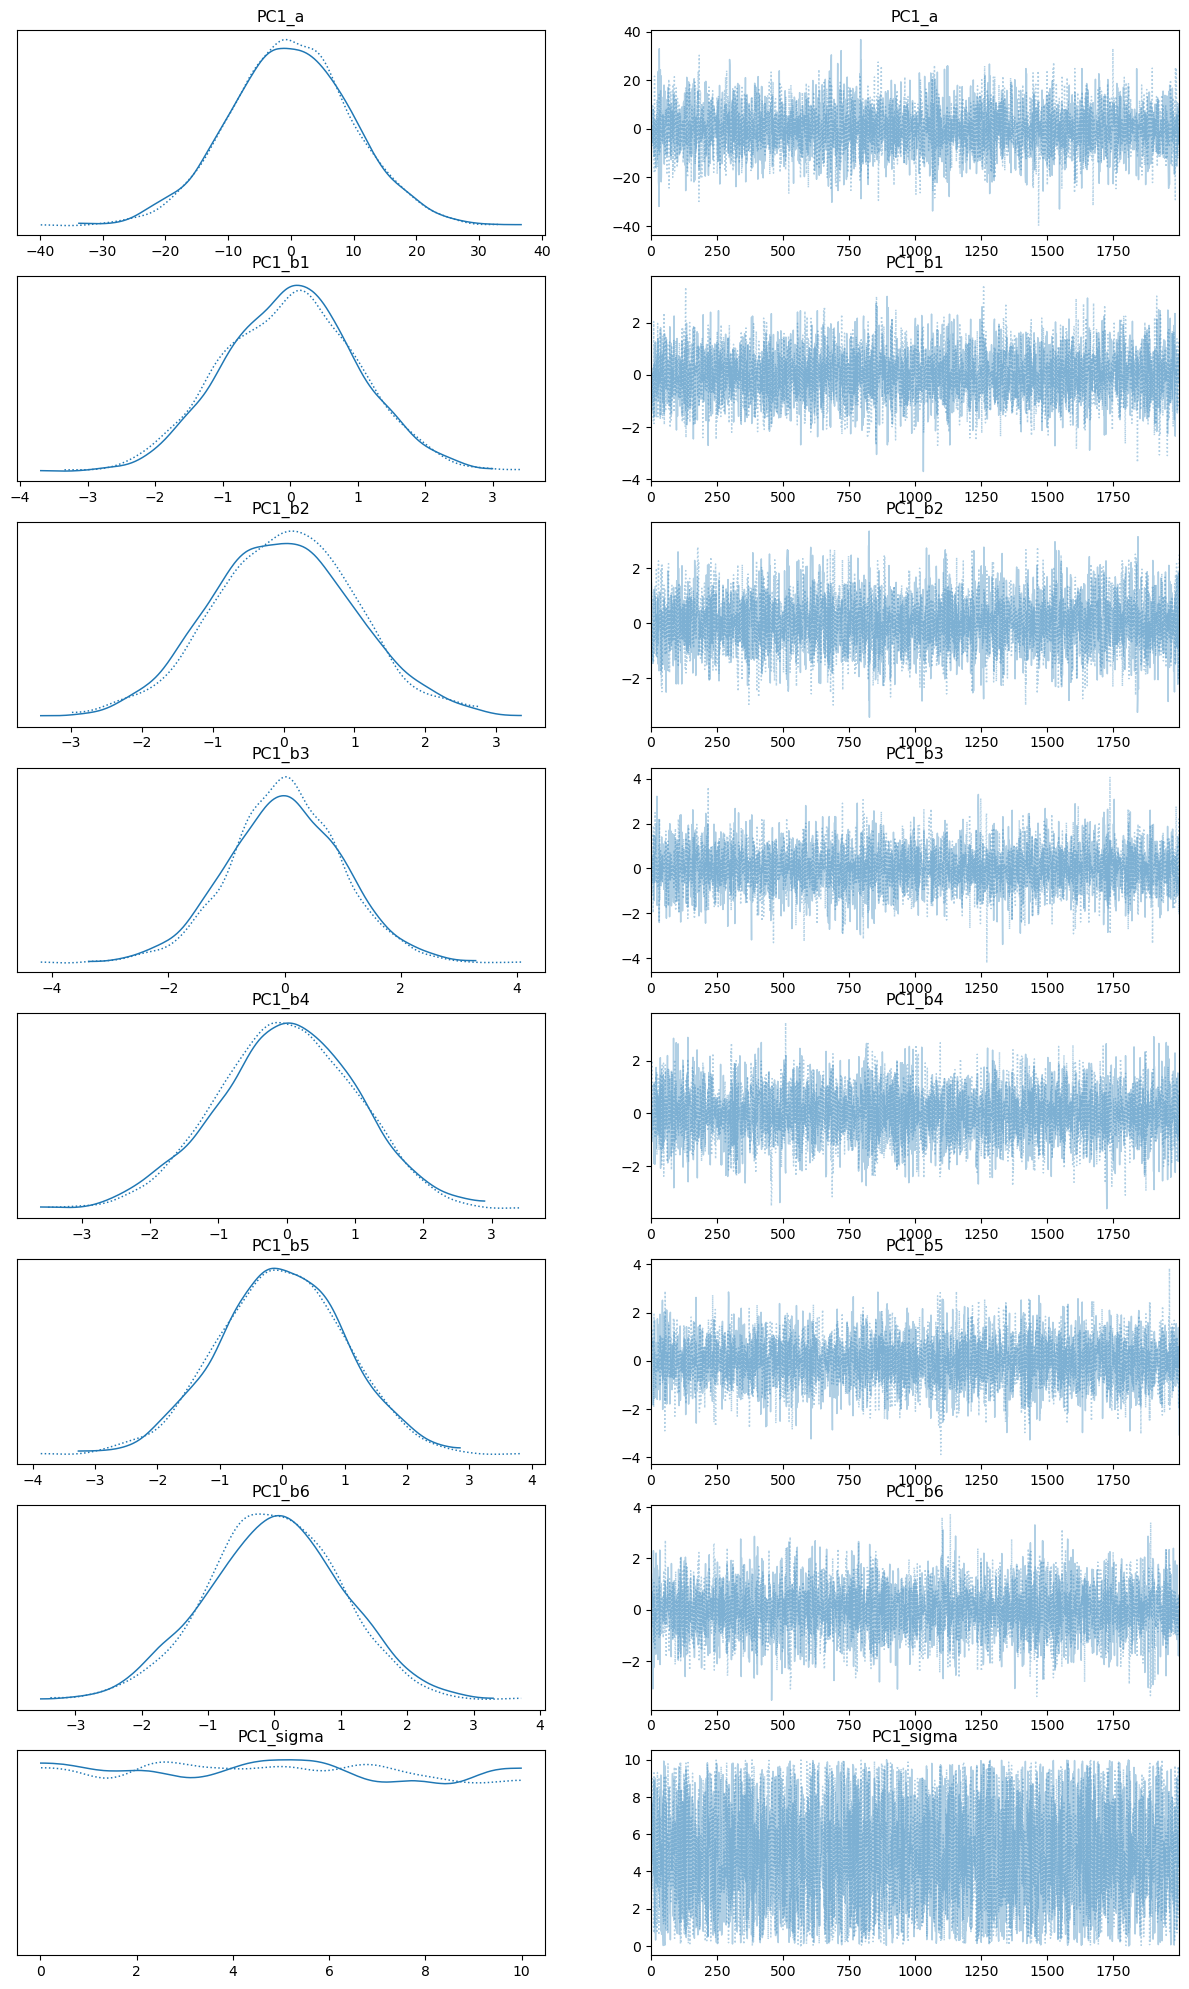

In [94]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 25));
